# Modelo para Reconhecimento de Expressões Faciais

In [9]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.metrics import categorical_accuracy
from keras.optimizers import *
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### Carregamento do dataset

In [10]:
# Carregando do meu drive pessoal devido ao tamanho do dataset
# Mas o arquivo original pode ser encontrado aqui: https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/overview
filename = '/content/drive/MyDrive/IFRS/fer2013.csv'
columns_names = ['emotion', 'pixels', 'usage']
df = pd.read_csv(filename, names=columns_names, na_filter=False)

df.head(3)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


### Carregamento e pré-processamento dos dados

In [11]:
def loadData(filename):
    X, Y = [], []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)

    return X, Y

X, Y = loadData(filename)
classes_count = len(set(Y))
print(f"Total de classes: {classes_count}")

Total de classes: 7


### Pré-processamento de dados e divisão em conjuntos de treino e teste

In [12]:
# Keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1) # Imagens são 48x48

from sklearn.model_selection import train_test_split

# Dividindo os dados X (imagens) e Y (rótulos) em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

# Convertendo os rótulos Y em one-hot encoding para treino
y_train = (np.arange(classes_count) == y_train[:, None]).astype(np.float32)

# Convertendo os rótulos Y em one-hot encoding para teste
y_test = (np.arange(classes_count) == y_test[:, None]).astype(np.float32)

### Gerando modelo

In [13]:
def createModel():
    model = Sequential()

    # 1ª camada Convolucional
    model.add(Conv2D(64, (5, 5), input_shape=(X_train.shape[1:]), activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2ª camada Convolucional
    model.add(Conv2D(128, (5, 5),activation='relu', padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª camada Convolucional
    model.add(Conv2D(256, (3, 3),activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Redes neurais totalmente conectadas
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       4

### Treinamento

In [14]:
keras.backend.clear_session() # Destrói os gráficos atuais e contrói outro
keras.backend.set_value(model.optimizer.lr, 1e-2) # Seta a taxa de aprendizado

# Treinar modelo
trained = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=32,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True
)

Epoch 1/32
505/505 [==============================] - 32s 41ms/step - loss: 1.7334 - accuracy: 0.3064 - val_loss: 1.9608 - val_accuracy: 0.2892
Epoch 2/32
505/505 [==============================] - 18s 35ms/step - loss: 1.4631 - accuracy: 0.4325 - val_loss: 1.4966 - val_accuracy: 0.4252
Epoch 3/32
505/505 [==============================] - 18s 35ms/step - loss: 1.2985 - accuracy: 0.5049 - val_loss: 1.3017 - val_accuracy: 0.5074
Epoch 4/32
505/505 [==============================] - 18s 36ms/step - loss: 1.1792 - accuracy: 0.5530 - val_loss: 1.3536 - val_accuracy: 0.4865
Epoch 5/32
505/505 [==============================] - 18s 36ms/step - loss: 1.0739 - accuracy: 0.5968 - val_loss: 1.1929 - val_accuracy: 0.5520
Epoch 6/32
505/505 [==============================] - 18s 36ms/step - loss: 0.9759 - accuracy: 0.6334 - val_loss: 1.2062 - val_accuracy: 0.5545
Epoch 7/32
505/505 [==============================] - 18s 36ms/step - loss: 0.8737 - accuracy: 0.6714 - val_loss: 1.1624 - val_accuracy:

### Gráficos de Desempenho do Modelo

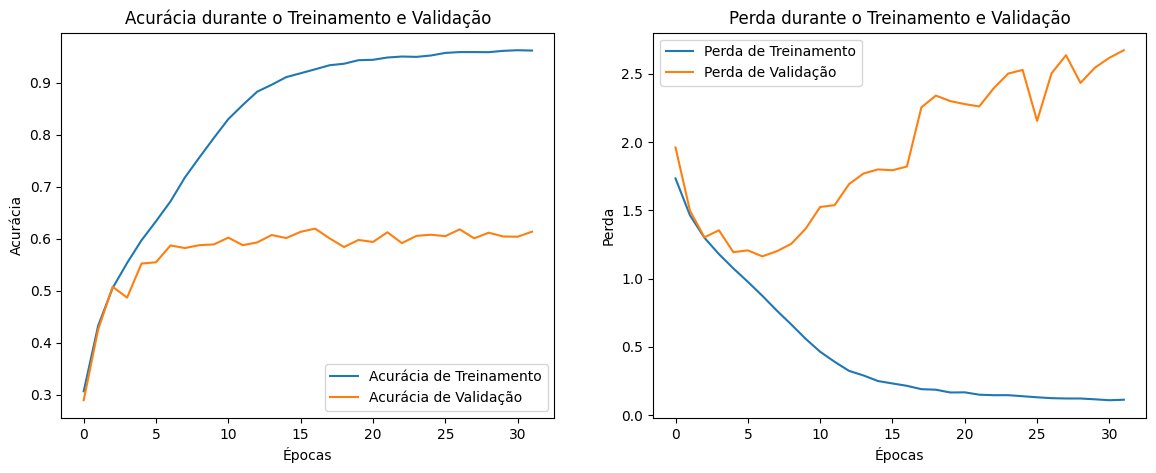

In [15]:
import matplotlib.pyplot as plt

# Gráfico de Precisão
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(trained.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(trained.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia durante o Treinamento e Validação')

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(trained.history['loss'], label='Perda de Treinamento')
plt.plot(trained.history['val_loss'], label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda durante o Treinamento e Validação')

plt.show()

### Avaliar performance de teste

In [20]:
from sklearn.metrics import accuracy_score

test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Acurácia do modelo CNN no teste: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 1s 6ms/step
Acurácia do modelo CNN no teste: 0.6133


### Análise usando Matriz de Confusão

In [21]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    # Normaliza
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='Valor verdadeiro',
        xlabel='Valor previsto'
    )

    # Rotaciona as labels e define o alinhamento
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Percorre os dados
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

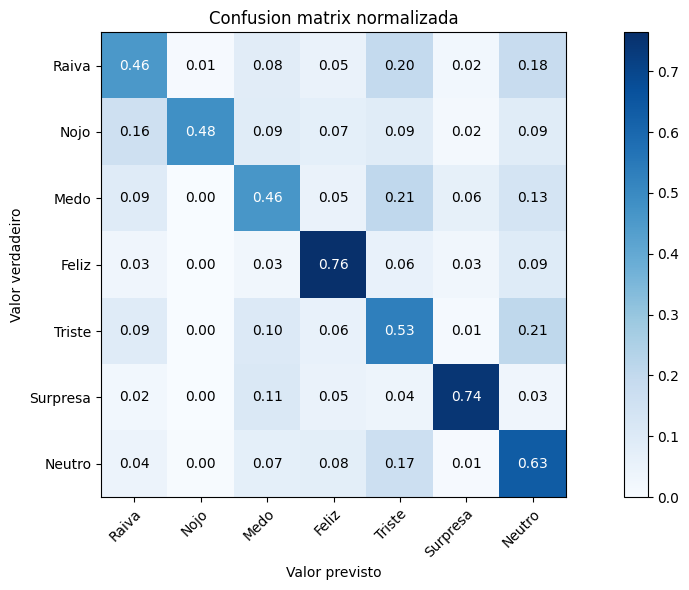

In [22]:
# Plota a matriz de confusão normalizada
emotion_labels = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpresa', 'Neutro']

plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, title='Matriz de confusão normalizada')
plt.show()

In [23]:
from keras.models import model_from_json

# Salva o modelo para ser usado posteriormente
with open("model.json", "w") as json_file:
    json_file.write(model.to_json())

model.save_weights("weights.h5")